### 0. Introduction
by: Bekhzod Urazimbatov - RY9I8G  
     Manar Al Raisi - HT8UEP         
     Mátyás Csanády - GXLS7D

### 1. Imports

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 2. Reading and transforming the data
We read the data from the raw measurements (csv files). Than we filetred them down to a shorter time period (2025-04-18 00:00 -> 2025-05-02 00:00). We index the values with their measurement dates and rounded them down to secods. This rounding was more than enough since our data was measure with steady 10 second intervals.

In [ ]:
flame = pd.read_csv("data/FireBox-flameAnalogRead.csv", index_col='time')
gas = pd.read_csv("data/FireBox-gasAnalogRead.csv", index_col='time')
humi = pd.read_csv("data/FireBox-humi.csv", index_col='time')
temp = pd.read_csv("data/FireBox-temp.csv", index_col='time')
pres2 = pd.read_csv("data/FireBox-presenceV2.csv", index_col='time')

print(flame)

dfs = [flame, gas, humi, temp, pres2]

start = pd.to_datetime('2025-04-18 00:00').tz_localize('UTC')
end   = pd.to_datetime('2025-05-02 00:00').tz_localize('UTC')

for i, df in enumerate(dfs):
    df.index = pd.to_datetime(df.index, utc=True).round('s')
    dfs[i]  = df.loc[(df.index >= start) & (df.index <= end)]
    
print(dfs[0])

                                value
time                                 
2025-04-09T17:42:18.071170945Z    932
2025-04-09T17:42:28.106860288Z    944
2025-04-09T17:42:38.244036009Z    944
2025-04-09T17:42:48.27956891Z     944
2025-04-09T17:42:58.314681035Z    944
...                               ...
2025-05-22T14:36:37.277496889Z    160
2025-05-22T14:36:47.417415828Z    161
2025-05-22T14:36:57.447272655Z    163
2025-05-22T14:37:07.487208228Z    177
2025-05-22T14:37:17.623262651Z    181

[352953 rows x 1 columns]
                           value
time                            
2025-04-18 00:00:07+00:00      1
2025-04-18 00:00:17+00:00      1
2025-04-18 00:00:27+00:00      1
2025-04-18 00:00:37+00:00      1
2025-04-18 00:00:47+00:00      1
...                          ...
2025-05-01 23:59:15+00:00      1
2025-05-01 23:59:25+00:00      1
2025-05-01 23:59:35+00:00      1
2025-05-01 23:59:45+00:00      1
2025-05-01 23:59:55+00:00      1

[118362 rows x 1 columns]


### 3. Simple line charts
To better visualize the data we plotted them in a simple line chart. Each measurment has its own chart, mean and limit (except the presence). To best handle this we created a function that handles these in a unified way. Also handles exporting them to pngs for an other presentation of ours.

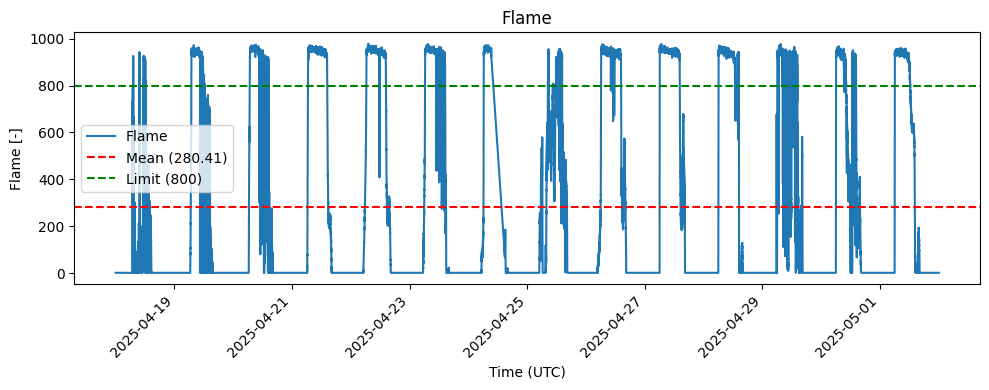

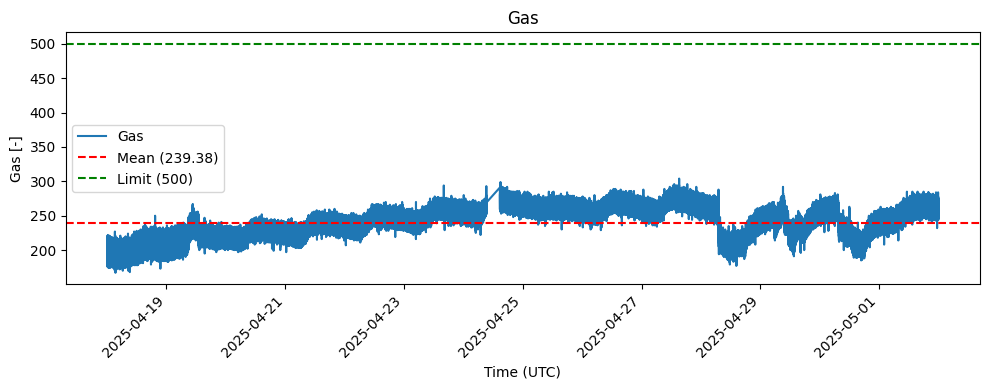

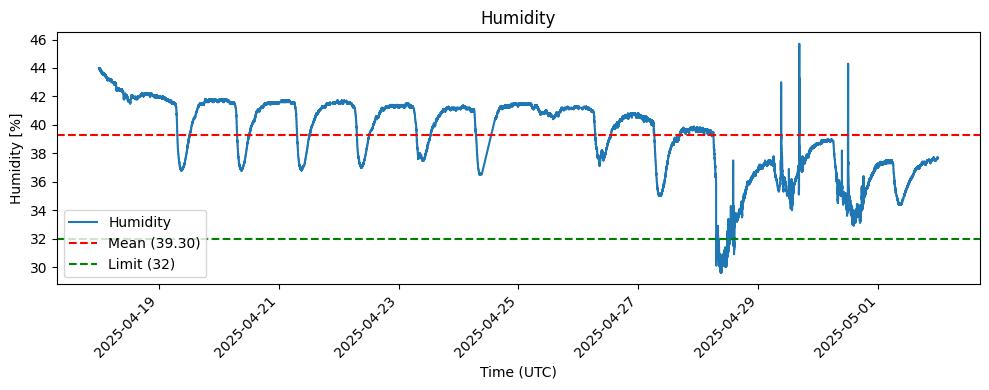

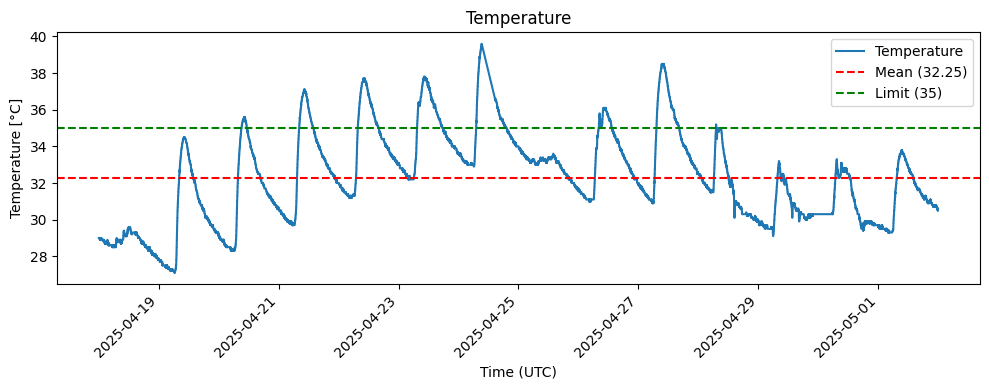

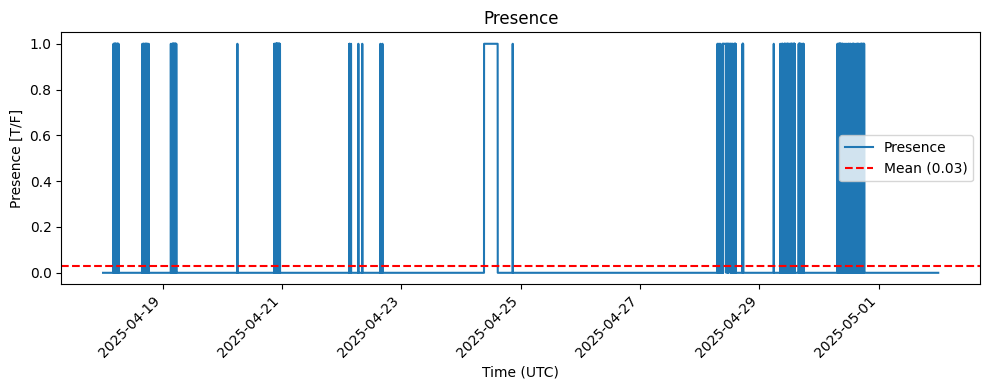

In [145]:
def plot_line_chart(data, title, y_label, limit=0):

    mean_val = data['value'].mean()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(data.index, data['value'], label=title)
    ax.axhline(mean_val, linestyle='--', color="red", label=f'Mean ({mean_val:.2f})')
    if limit:
        ax.axhline(limit, linestyle='--', color="green", label=f'Limit ({limit:})')

    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    fig.savefig(f'plots/line/{title.split()[0]}.png', dpi=300, bbox_inches='tight')
    

plot_line_chart(dfs[0], "Flame", "Flame [-]", 800)
plot_line_chart(dfs[1], "Gas", "Gas [-]", 500)
plot_line_chart(dfs[2], "Humidity", "Humidity [%]", 32)
plot_line_chart(dfs[3], "Temperature", "Temperature [°C]", 35)
plot_line_chart(dfs[4], "Presence", "Presence [T/F]")


### 4. Thresholds breached
If any of the thresholds were breached, that meant an increased chance of fire. We collected all the times in the time interval when the measured data breached the treshold. We had to keep in mind that the humiditty threshold was a lower limit while all the others were upper limits, so we introduced diffrenet comparision methods.

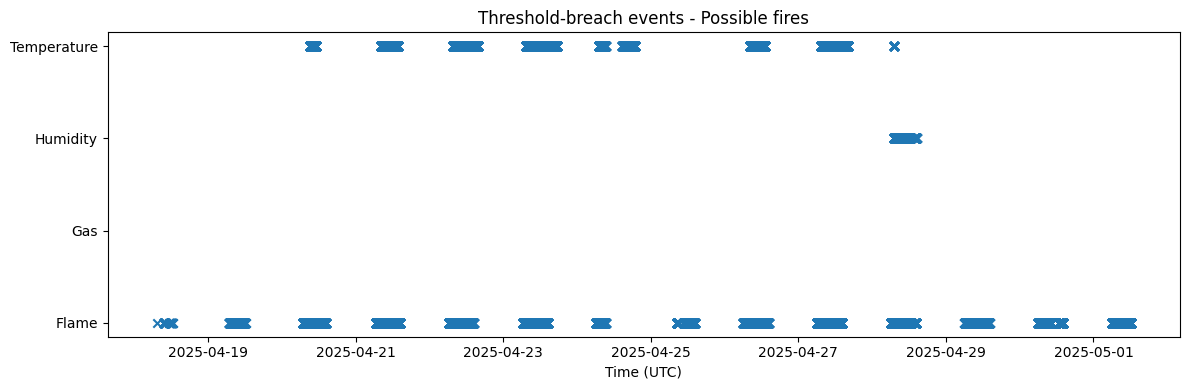

In [146]:
data = {
    'Flame'      : dfs[0],
    'Gas'        : dfs[1],
    'Humidity'   : dfs[2],
    'Temperature': dfs[3],
}
limits = {
    'Flame'      : (800,  'gt'),
    'Gas'        : (500,  'gt'),
    'Humidity'   : (32,   'lt'),   # humidity breaches when too low
    'Temperature': (35,   'gt'),
}


events = []
for name, df in data.items():
    val = df['value']
    thresh, cmp = limits[name]
    if cmp == 'gt':
        mask = val > thresh
    else:
        mask = val < thresh

    times = df.index[mask]
    for t in times:
        events.append((t, name))

events_df = pd.DataFrame(events, columns=['time','sensor'])

fig, ax = plt.subplots(figsize=(12, 4))

sensors = list(data.keys())
ypos = {sensor:i for i, sensor in enumerate(sensors)}

ax.scatter(
    events_df['time'],
    events_df['sensor'].map(ypos),
    marker='x'
)

ax.set_yticks(list(ypos.values()))
ax.set_yticklabels(sensors)
ax.set_xlabel('Time (UTC)')
ax.set_title('Threshold-breach events - Possible fires')
plt.tight_layout()
plt.show()


### 5. Boxplots
We were also interested at the distribution of values so we created boxplots to visualize them

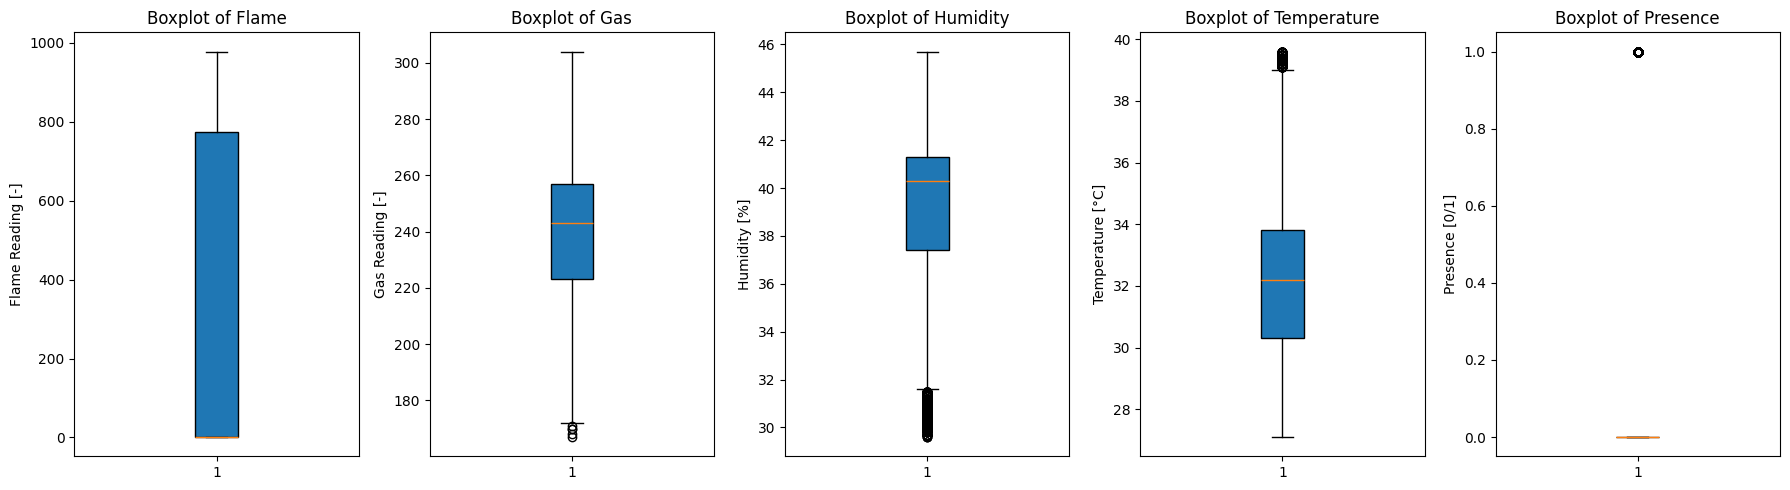

In [147]:
titles   = ['Flame', 'Gas', 'Humidity', 'Temperature', 'Presence']
ylabels  = ['Flame Reading [-]', 'Gas Reading [-]', 'Humidity [%]', 'Temperature [°C]', 'Presence [0/1]']

plt.figure(figsize=(18, 5))

for i, df in enumerate(dfs[:5]):
    vals = df['value']
    if vals.dtype == 'bool':
        vals = vals.astype(int)
    
    ax = plt.subplot(1, 5, i+1)
    ax.boxplot(vals, patch_artist=True)
    ax.set_title(f'Boxplot of {titles[i]}')
    ax.set_ylabel(ylabels[i])

plt.tight_layout()
plt.show()


### 6. Correlation matrix
To better understand the realtions of the measured values we created a correlation matrix, that presented us with the correlation data. For this we used a seaborn heatmap.

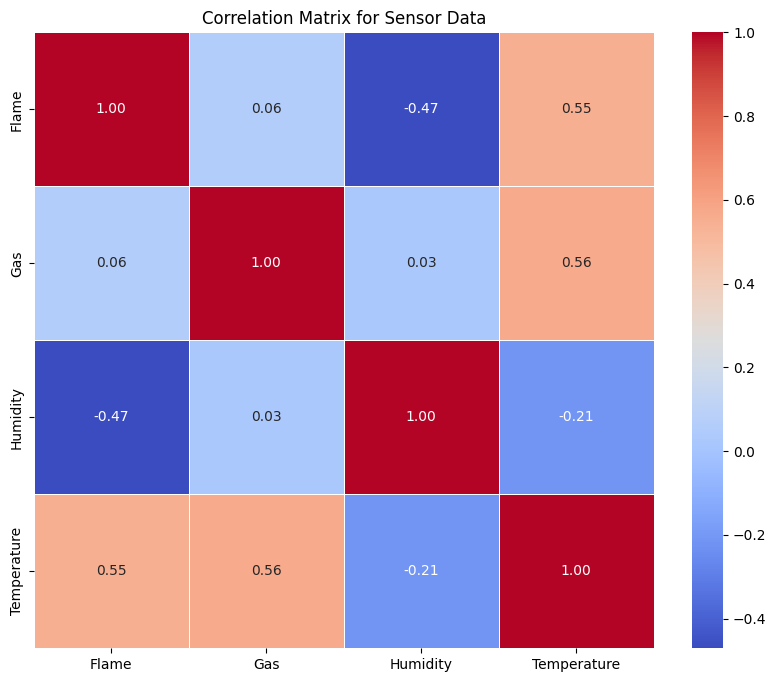

In [148]:
import seaborn as sns

merged_data = pd.concat(dfs[:-1], axis=1, join='outer')
merged_data.columns = ["Flame", "Gas", "Humidity", "Temperature"]
correlation_matrix = merged_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Sensor Data')
plt.show()